Tuesday 2/03/2021

* Distilled useful code from previous days
* Implemented vanilla autoencoder as per Keras blog (+ dense layer to implement bottleneck)

NEXT:
* Train network several times, on same or different dataset. Anything changes?
* Change NN
 * Drop padding. Does it change anything?
 * Add filters
 * Add another dense layer
 * VAE
* Add 3rd lat variable


In [1]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
%load_ext tensorboard

import pickle

## Dataset

In [176]:
from env import ArmRobotEnv
env = ArmRobotEnv()

C:\Users\alexa\anaconda3\envs\tf-gpu1\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Generate

In [177]:
import time

def gen_data(N):
    """
    Generate testdata: actions and robot views
    """
    env.reset()

    print("Generating %d datapoints ... (approx %f sec)" % (N, N*0.035)) # FIXME
    
    start_time = time.time()
    for i in range(N):
        action = env.env.action_space.sample()
        obs, _reward, _done, _info = env.step(action)
        env.render()
        y = env.get_image()
        
        if i == 0:
            A = np.zeros([N] + list(action.shape))
            Y = np.zeros([N] + list(y.shape))

        A[i] = action.flatten()
        Y[i] = y
  
    elapsed = time.time() - start_time
    print("Generated %d data points. Actual time: %.1fs (%f sec/datapoint)" % (N, elapsed, elapsed/N))

    return {'A': A, 'Y': Y}

In [180]:
gen_data(10)['Y'].shape

Generating 10 datapoints ... (approx 0.350000 sec)
Generated 10 data points. Actual time: 0.3s (0.032415 sec/datapoint)


(10, 64, 64, 1)

### Load the dataset

In [3]:
with open('dataset-random-100k.mdict.pickle', 'rb') as handle:
    [train, val, test] = pickle.load(handle)

print(train['Y'].shape)
print(train.keys())

(100000, 64, 64, 1)


### Visualize statistical distribution of the dataset

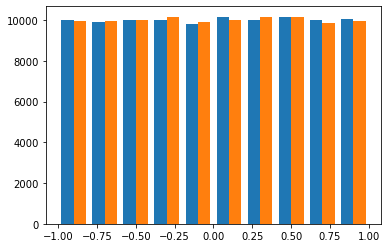

In [99]:
_=plt.hist(train['A'])

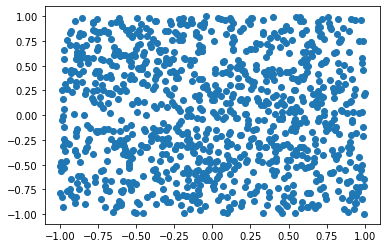

In [100]:
_=plt.scatter(train['A'][:1000,0], train['A'][:1000,1])

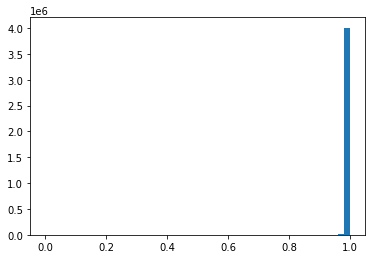

In [179]:
_=plt.hist(train['Y'][:1000].flatten(), bins=50)

### Visualize some images from the dataset

In [103]:
def _clean_ax(ax):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
def _imshow(ax, img):
    if img is not None:
        ax.imshow(img, cmap='Greys', origin='lower')
    _clean_ax(ax)
        
def plot_Y(img_array):
    assert(img_array.shape[-1] == 1)
    fig, axs = plt.subplots(figsize=(2, 2))
    _imshow(axs, img_array[..., 0])
    return fig, axs

def plot_Ys(img_array, title=None, ncols=5):
    assert(ncols > 0)

    nimgs = img_array.shape[0]
    if nimgs == 0:
        return None, None
    elif nimgs == 1:
        return plot_Y(img_array[0,...])
    elif nimgs <= ncols:
        ncols = nimgs
        fig, axs = plt.subplots(1, ncols, figsize=(2*ncols, 2))

        for i in range(ncols):
            _imshow(axs[i], img_array[i,...])
    else:
        nrows = int((nimgs-1)/ ncols) + 1
        fig, axs = plt.subplots(nrows, ncols, figsize=(2*ncols, 2*nrows))

        for i in range(nrows):
            for j in range(ncols):
                k = i*ncols + j
                if k < nimgs:
                    img = img_array[k,...]
                else:
                    img = None
                _imshow(axs[i][j], img)
                    
    if title is not None:
        fig.suptitle("%s (%s)" % (title, str(img_array.shape)))
        
    return fig, axs

In [104]:
#_=plot_Y(train_Y[0,...])
#_=plot_Ys(train_Y[0:1,...])
#_=plot_Ys(train_Y[0:5,...])
#_=plot_Ys(train_Y[0:6,...])
#_=plot_Ys(train_Y[0:24,...])

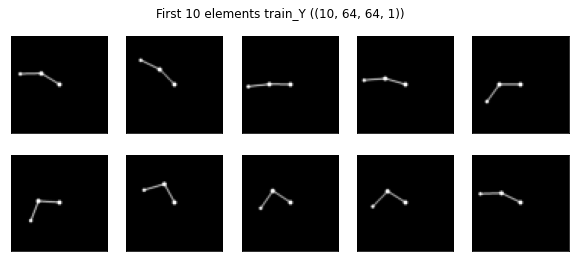

In [105]:
_=plot_Ys(train['Y'][0:10,...], title="First 10 elements train_Y")

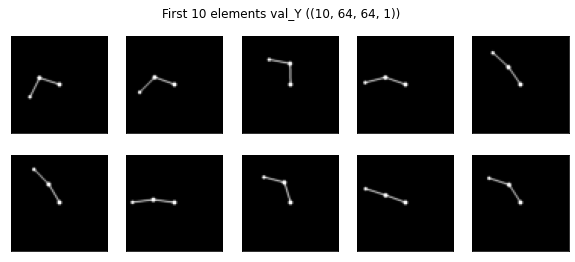

In [106]:
_=plot_Ys(val['Y'][0:10,...], title="First 10 elements val_Y")

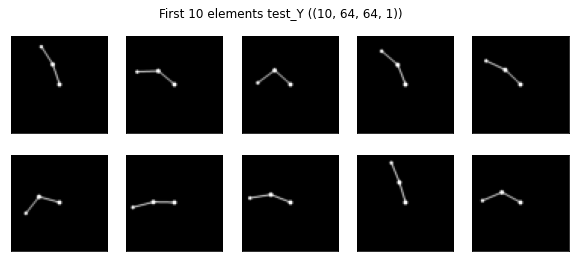

In [107]:
_=plot_Ys(test['Y'][0:10,...], title="First 10 elements test_Y")

## Model

### - Load

In [70]:
def load_models(prefix):
    model = dict()
    for k in ['ae', 'enc', 'dec']:
        fname = prefix + '-' + k + '.h5'
        model[k] = keras.models.load_model(fname)
    return model

In [71]:
#autoencoder = load_models("autoencoder-double100k-2")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Build vanilla autoencoder with a bottleneck

In [144]:
from models.ae_keras_vanilla import build_conv_autoencoder

In [145]:
autoencoder = build_conv_autoencoder(train['Y'].shape[1:], 2)

In [147]:
import os, datetime

def train_model(model, train, val):
    ae = model['ae']
    
    logdir = os.path.join("20210302-ae_keras_vanilla-1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir) #, histogram_freq=1)
    
    ae.fit(train['Y'], train['Y'], validation_data=(val['Y'], val['Y']), callbacks=[tensorboard_callback],
           epochs=50, batch_size=128, verbose=1)

In [148]:
train_model(autoencoder, train, val)

Train on 100000 samples, validate on 100 samples
Epoch 1/50
100000/100000 [==============================] - 15s 147us/sample - loss: 0.0481 - val_loss: 0.0263
Epoch 2/50
100000/100000 [==============================] - 13s 135us/sample - loss: 0.0228 - val_loss: 0.0175
Epoch 3/50
100000/100000 [==============================] - 13s 135us/sample - loss: 0.0167 - val_loss: 0.0166
Epoch 4/50
100000/100000 [==============================] - 13s 135us/sample - loss: 0.0163 - val_loss: 0.0163
Epoch 5/50
100000/100000 [==============================] - 13s 135us/sample - loss: 0.0161 - val_loss: 0.0163
Epoch 6/50
100000/100000 [==============================] - 14s 139us/sample - loss: 0.0160 - val_loss: 0.0160
Epoch 7/50
100000/100000 [==============================] - 13s 133us/sample - loss: 0.0155 - val_loss: 0.0149
Epoch 8/50
100000/100000 [==============================] - 14s 136us/sample - loss: 0.0140 - val_loss: 0.0140
Epoch 9/50
100000/100000 [==============================] - 14s

Y.shape=(100000, 64, 64, 1)
L.shape=(100000, 2)
YY.shape=(100000, 64, 64, 1)


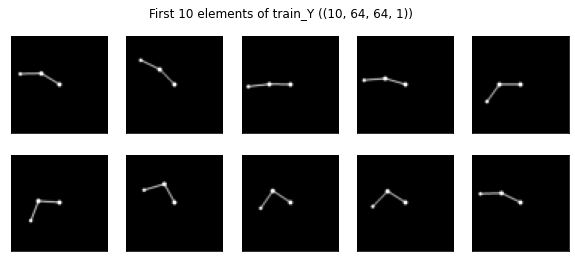

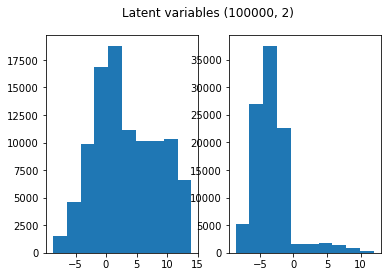

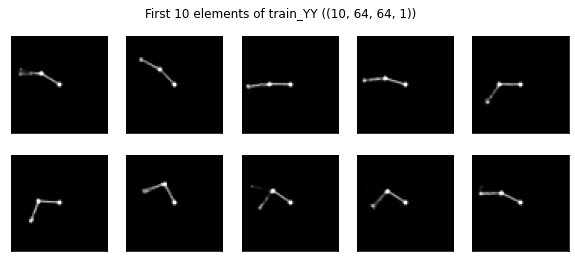

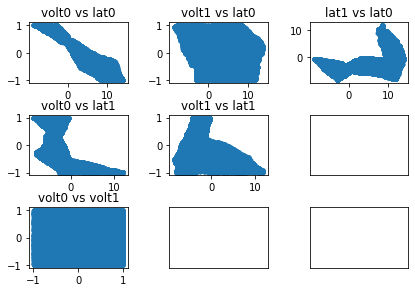

In [150]:
_=cycle_autoencoder(autoencoder, train, prefix="train_")

Y.shape=(100, 64, 64, 1)
L.shape=(100, 2)
YY.shape=(100, 64, 64, 1)


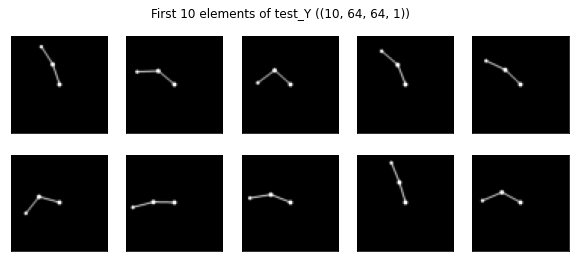

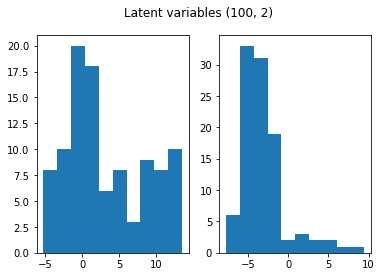

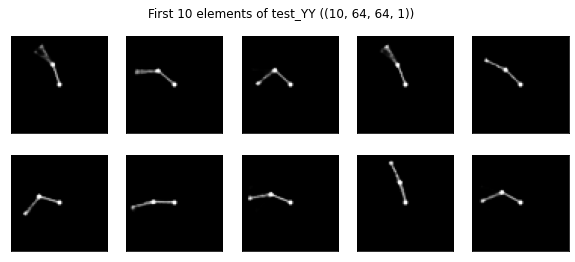

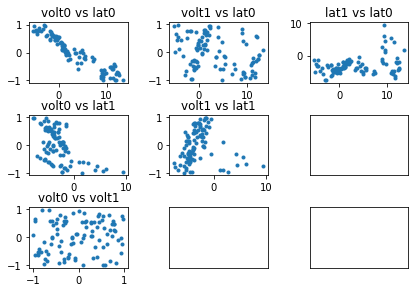

In [151]:
_=cycle_autoencoder(autoencoder, test, prefix="test_")

## Handling new data

In [202]:
new_val = gen_data(10000)

Generating 10000 datapoints ... (approx 350.000000 sec)
Generated 10000 data points. Actual time: 328.9s (0.032892 sec/datapoint)


Y.shape=(10000, 64, 64, 1)
L.shape=(10000, 2)
YY.shape=(10000, 64, 64, 1)


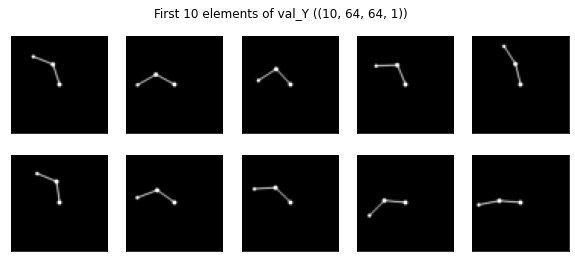

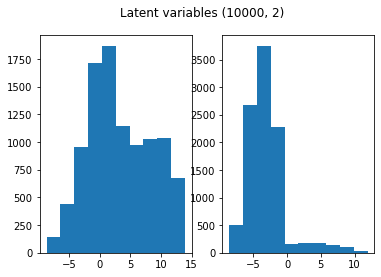

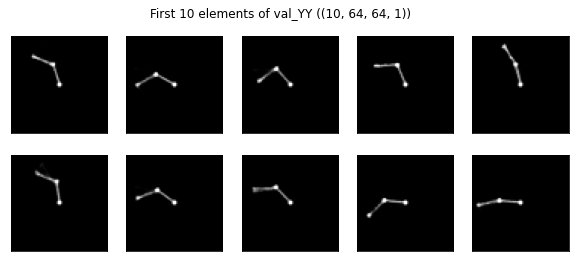

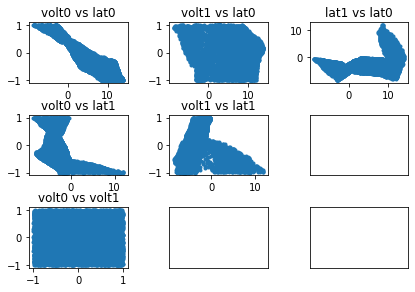

In [203]:
new_val_out = cycle_autoencoder(autoencoder, new_val, prefix="val_")

In [235]:
def fine_scatter(data1, x1, i1, data2, x2, i2):
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.scatter(data1[x1][:,i1], data2[x2][:,i2], 1)
    ax.set_xlabel("%s%d" % (x1, i1))
    ax.set_ylabel("%s%d" % (x2, i2))
    ax.grid()

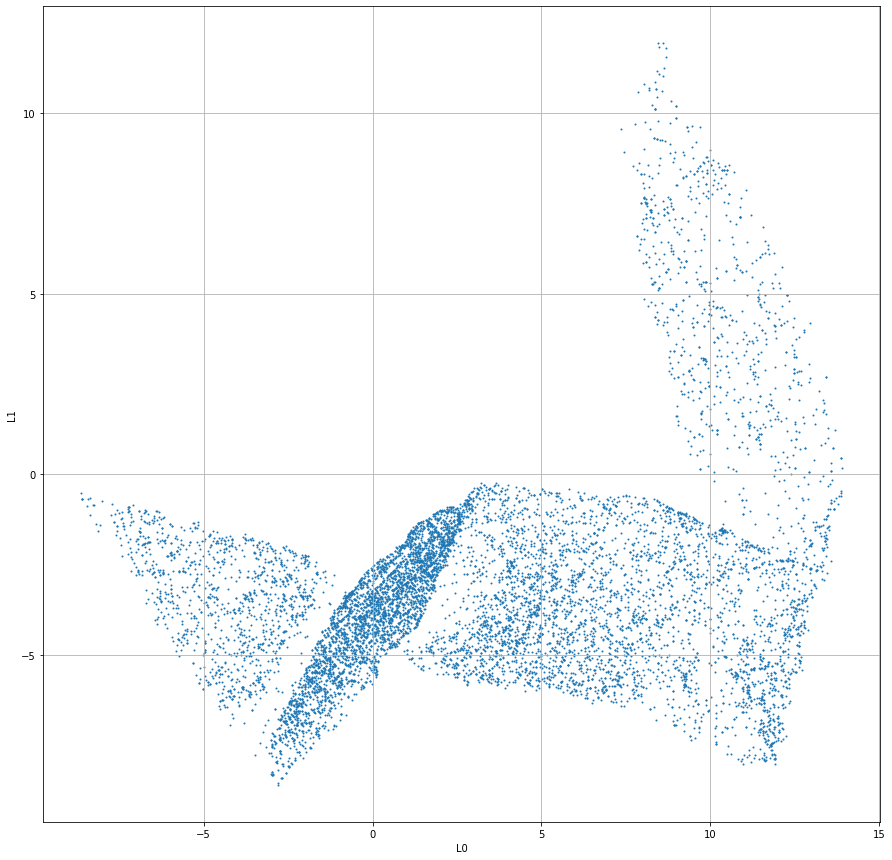

In [236]:
fine_scatter(new_val_out, 'L', 0, new_val_out, 'L' , 1)

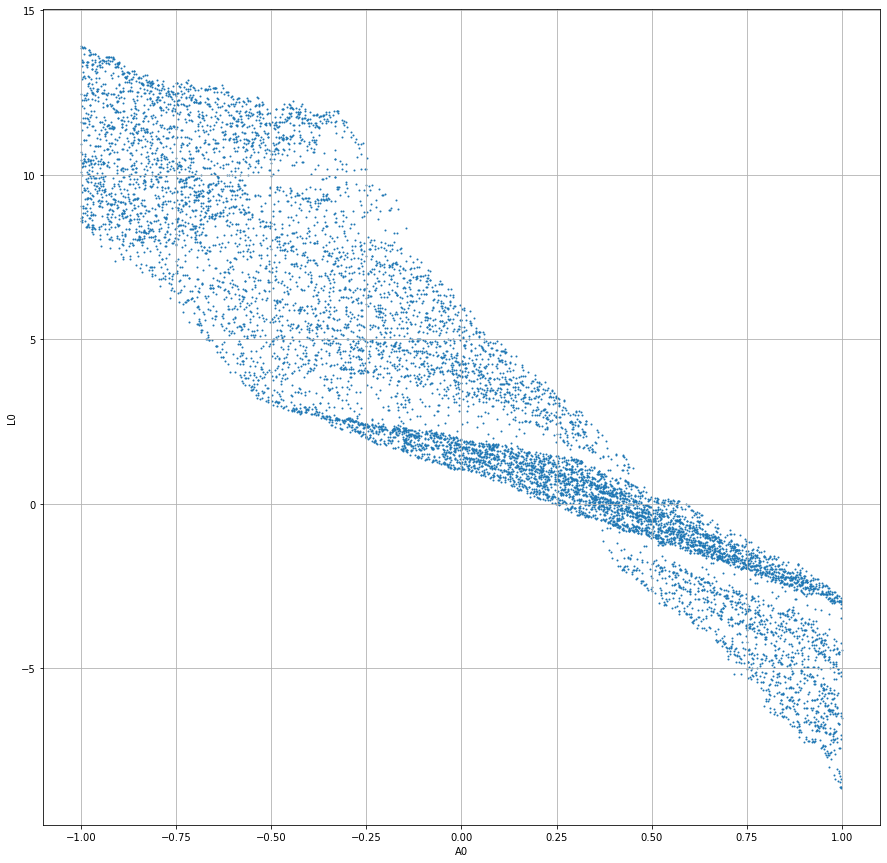

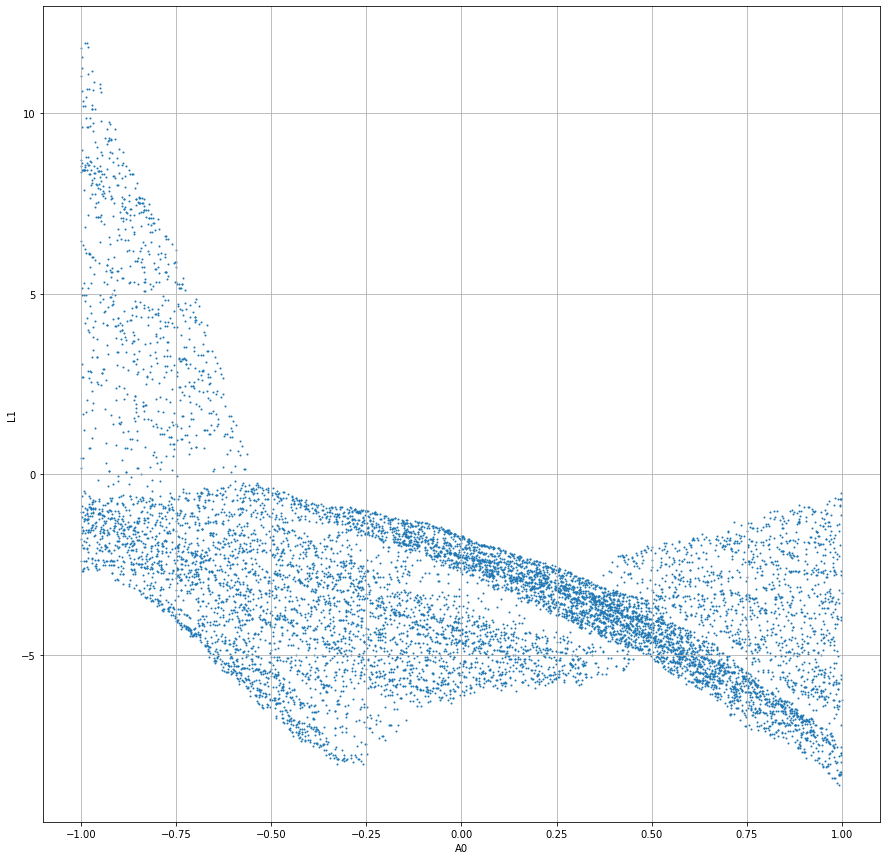

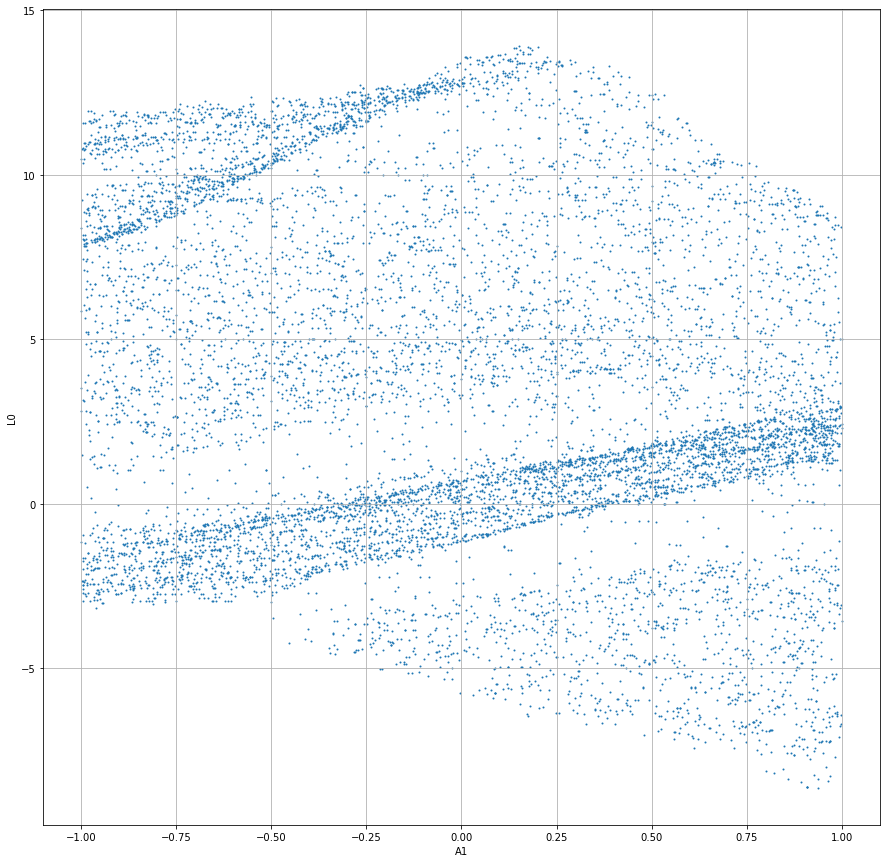

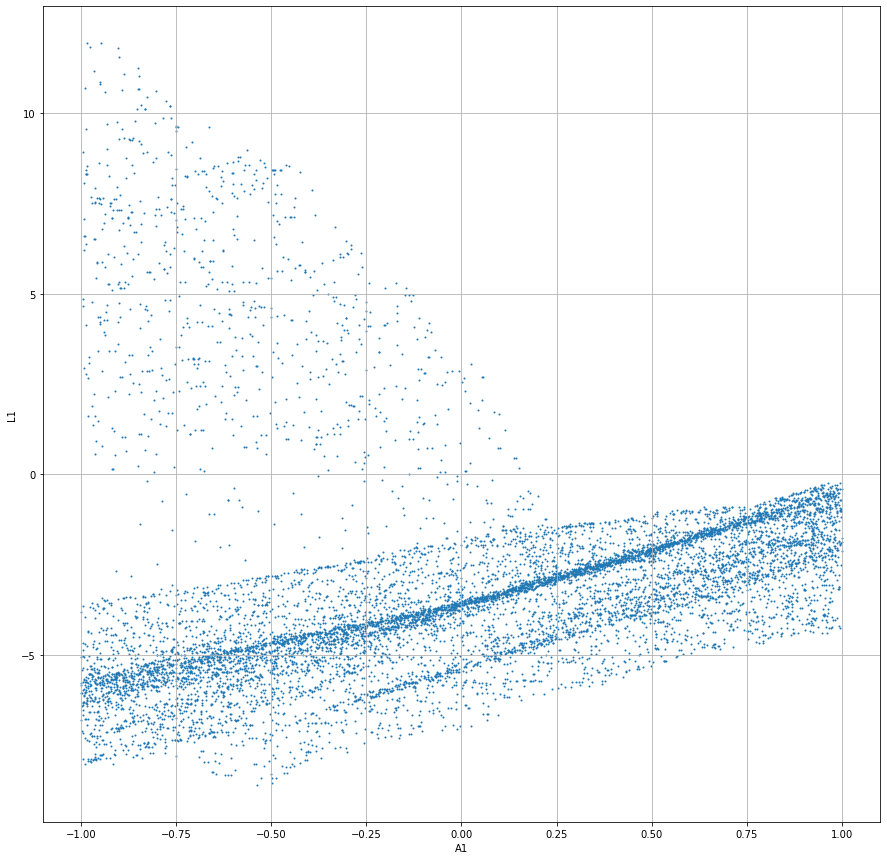

In [234]:
fine_scatter(new_val, 'A', 0, new_val_out, 'L' , 0)
fine_scatter(new_val, 'A', 0, new_val_out, 'L' , 1)
fine_scatter(new_val, 'A', 1, new_val_out, 'L' , 0)
fine_scatter(new_val, 'A', 1, new_val_out, 'L' , 1)


In [219]:
play_with_sliders(autoencoder, [[2, 10], [-5,-1]])

Output()

FloatSlider(value=2.0, max=10.0, min=2.0, step=0.01)

FloatSlider(value=-1.0, max=-1.0, min=-5.0, step=0.01)

Button(description='Redraw', style=ButtonStyle())

# Tools

## Visualize performance of the model

In [185]:
def display_xvars(data):
    nLat = data['L'].shape[1]
    nVoltages = data['A'].shape[1]

    fig, axs = plt.subplots(nLat+1, nVoltages+1)
    fig.tight_layout()

    for i in range(nLat):
      for j in range(nVoltages):
        title = "volt%d vs lat%d" % (j, i)
        axs[i][j].title.set_text(title)
        axs[i][j].plot(data['L'][:, i], data['A'][:,j], '.')

    axs[nLat][0].title.set_text("volt0 vs volt1")
    axs[nLat][0].plot(data['A'][:,1], data['A'][:,0], '.')

    axs[0][nVoltages].title.set_text("lat1 vs lat0")
    axs[0][nVoltages].plot(data['L'][:,0], data['L'][:,1], '.')

    _clean_ax(axs[1][2])
    _clean_ax(axs[2][1])
    _clean_ax(axs[2][2])

def cycle_autoencoder0(ae, data, prefix="", N=10):
    out_data = dict()
    
    Y = data['Y']
    
    print("Y.shape=" + str(Y.shape))
    YY = ae['ae'].predict(Y)
    YY = np.array(YY)
    print("YY.shape=" + str(YY.shape))
    
    out_data['YY'] = YY

    # - Y
    plot_Ys(Y[0:N,...], title="First %d elements of %sY" % (N, prefix))
   
    # - YY
    plot_Ys(YY[0:N,...], title="First %d elements of %sYY" % (N, prefix))
    
    return out_data

def cycle_autoencoder(ae, data, prefix="", N=10):
    Y = data['Y']
    
    print("Y.shape=" + str(Y.shape))
    L = ae['enc'].predict(Y)
    L = np.array(L)
    print("L.shape=" + str(L.shape))
    YY = ae['dec'].predict(L)
    YY = np.array(YY)
    print("YY.shape=" + str(YY.shape))
    
    data['L'] = L # FIXME
    data['YY'] = YY # FIXME

    out_data = dict()
    out_data['L'] = L
    out_data['YY'] = YY

    # - Y
    plot_Ys(Y[0:N,...], title="First %d elements of %sY" % (N, prefix))

    # - L
    fig, axs = plt.subplots(1, L.shape[1])
    fig.suptitle("Latent variables %s" % (str(L.shape)))
    for i in range(L.shape[1]):
        axs[i].hist(L[:,i])    
    
    # - YY
    plot_Ys(YY[0:N,...], title="First %d elements of %sYY" % (N, prefix))
    
    display_xvars(data)
    
    return out_data    

In [ ]:
#cycle_autoencoder0(autoencoder, train, prefix="train_")

In [ ]:
#cycle_autoencoder(autoencoder, train, prefix="train_")

In [ ]:
#cycle_autoencoder(autoencoder, val, prefix="val_")

In [ ]:
#cycle_autoencoder(autoencoder, test, prefix="test_")

## Play with Sliders

In [172]:
import ipywidgets as widgets
from IPython.display import display

def play_with_sliders(ae, ranges):
    nlats = len(ranges)
    
    sliders = []
    for i in range(nlats):
        sliders.append(widgets.FloatSlider(value=0.0, min=ranges[i][0], max=ranges[i][1], step=0.01))

    button = widgets.Button(description="Redraw")
    output = widgets.Output()

    def redraw(_=None):
        with output:
            output.clear_output(wait=True)
            #print("# %f %f" % (slider0.value, slider1.value))

            lats = []
            for i in range(nlats):
                lats.append(sliders[i].value)
                
            L = np.array([np.array(lats)])
            print(L.shape)
            Ys = ae['dec'].predict(L)[0,...,0]

            plt.clf()
            plt.imshow(Ys, cmap='Greys')
            plt.show()

    # ---
    
    ws = [output]
    
    for i in range(nlats):
        sliders[i].observe(redraw, names='value')
        ws.append(sliders[i])
        
    ws.append(button)
    button.on_click(redraw)
    
    display(*ws)
    redraw()

In [ ]:
#play_with_sliders(autoencoder, [[2, 10], [-5,-1]])